## Importing my data bases 

In [ ]:
## Importing my data bases and panda
import pandas as pd

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_df = pd.read_csv(path)

# brands_cl.csv
url = "https://drive.google.com/file/d/1XGyabaa4mAkjixMk3XPgx_14OoSse3rs/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
brands_df = pd.read_csv(path)




In [ ]:
import os
# Define paths using os.path.expanduser
orders_path = os.path.expanduser("~/Downloads/orders_qu.csv")
orderlines_path = os.path.expanduser("~/Downloads/orderlines_qu.csv")

In [ ]:
# Read the CSV files into pandas DataFrames
orders_df = pd.read_csv(orders_path)
orderlines_df = pd.read_csv(orderlines_path)


## I want to display always 2 decimal and columns and rows larger

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 1000)

## Discovering the date for database


It is beetween '2017-01-01 01:51:47', '2018-03-14 12:03:52'

In [ ]:
orders_df['created_date'].min(), orders_df['created_date'].max()


In [ ]:
orders_df

## Discovering overall revenue

its = 7978675 

In [ ]:
orders_df['total_paid'].sum().round()

## Are there seasonal patterns in the evolution of sales?

#### First i need to change created_date type into datetime64

In [ ]:
## changing created_date into datetime object
orders_df["created_date"] = pd.to_datetime(orders_df["created_date"])
orders_df.info()

#### Resampling and putting it into plot

In [ ]:
(
    orders_df
    .resample("ME", on='created_date')['total_paid']
    .sum()
    .plot()
)

## What is the most sold product?

In [ ]:
products_df

#### I want to make table to have a count of sells for product

In [ ]:
## making copy so i dont interfere the original data
orderlines_qu_temporary = orderlines_df.copy()

##### im merging so i see the product name on my table

In [ ]:
## dont run this cause it will make another copy of column
orderlines_qu_temporary = orderlines_qu_temporary.merge(products_df[['sku', 'name']], on='sku', how='left')



In [ ]:
#### the most sales products are = 
products_sales = orderlines_qu_temporary.groupby('name')['product_quantity'].sum().sort_values(ascending=False)

products_sales.head(10)


### FINDING: Apple Care Protection Plan is most sold product
##### ~~~Its probably addition to some products, so i'll pursue the finding and check it~~ its not addition

In [ ]:
orderlines_qu_temporary.loc[orderlines_qu_temporary['name'] == 'IPhone AppleCare Protection Plan', :]

## What are the products that generate the most revenue?

#### I will add column with price paid so the products with multiple product quantity will be counted 

In [ ]:
## We'll use the copy of data with merged names so we dont repeat that step
orderlines_qu_temporary.loc[:, 'price_paid'] = orderlines_qu_temporary['unit_price'] * orderlines_qu_temporary['product_quantity']


#### Now i will group by price_paid to find which products generate most revenue

In [ ]:
(
    orderlines_qu_temporary
    .groupby('name')['price_paid']
    .sum()
    .sort_values(ascending=False)#.head(20)
)

## Discount Analyze

#### I need to merge orderlines with products to compare first price with actual price paid


In [ ]:
## im merging two databases on sku (foreign key), assaign it to new name (orderlines_products)(names of two tables)
orderlines_products = orderlines_df.merge(products_df, on= 'sku', how='left')

#### Now i want to drop unsueful columns using .drop


In [ ]:
orderlines_products.drop(['product_id', 'id', 'in_stock', 'desc', 'type'], axis=1, inplace=True)

In [ ]:
orderlines_products

#### Making discount column (Just a number)

In [ ]:
orderlines_products.loc[:, 'Discount'] = orderlines_products['price'] - orderlines_products ['unit_price']

In [ ]:
orderlines_products

#### Making discount column (percentage)

In [ ]:
orderlines_products.loc[:, 'Discount%'] = ((orderlines_products['price'] - orderlines_products ['unit_price'])/ orderlines_products['price']) * 100

## im rounding the result with no decimal 
orderlines_products['Discount%'] = orderlines_products['Discount%'].round().astype(int)

In [ ]:
orderlines_products

## I want to see what is overall discount

##### overall discounted number = 1390216


In [ ]:
orderlines_products['Discount'].sum()

##  ! finding that sometimes people paid more than regular price !

#### making other table just with negative discounts

In [ ]:
## im pursuing to find whats going on with negative discounts
negative_discount = orderlines_products.loc[orderlines_products['Discount'] < 0, :]

In [ ]:
## covnerting to data object
negative_discount["date"] = pd.to_datetime(negative_discount["date"])


In [ ]:
### Checking the distribution on when people overpay
(
    negative_discount
    .resample("D", on="date")
    .sum()['Discount']
    .abs()
    .plot(figsize=(12, 8))
)

#### people overpay especially on first 2.5 months and between May - September (inklusive) WHY?
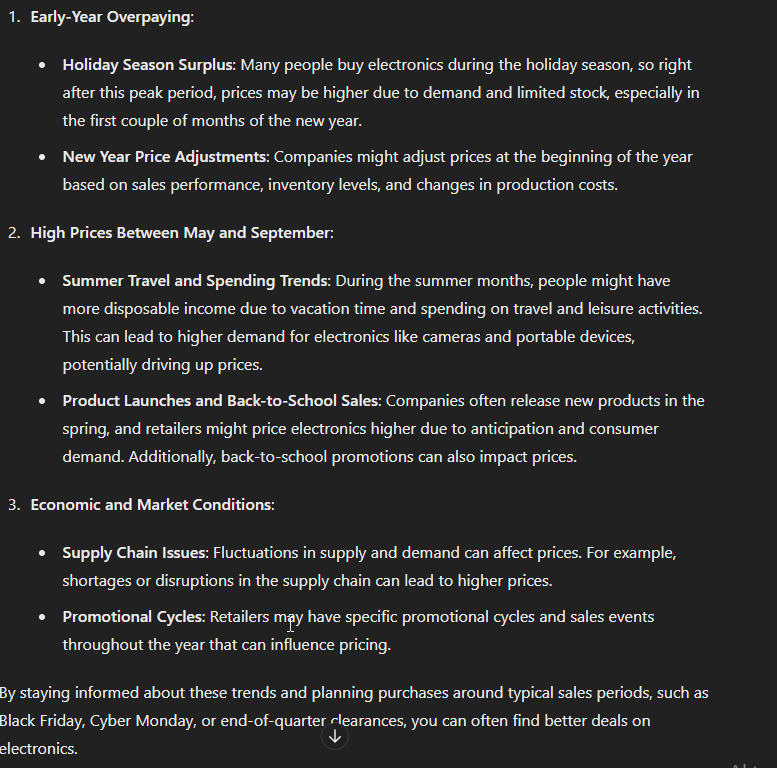

## Going back to find what % of revenue are discounts

#### Back to using orderlines_products

In [ ]:
orderlines_products['Discount%'].mean()

##### Average discount for order is 21%

## Now i want to analyze the correlation between the discount and the revenue

#### i want to somehow establish total discount on total_paid on orders_qu so i can look for correlation

In [ ]:
discovery_df = orders_df.merge(orderlines_products, left_on='order_id', right_on= 'id_order', how='inner')

In [ ]:
discovery_df.duplicated().sum()

In [ ]:
discovery_df['Discount'].corr(discovery_df['total_paid'])

#### IM NOT SURE THAT IS ACCURATE (above) (dont know if i merged it correctly) but the result 0.21 means that relationship between discounts and revenue is not very strong, but there is a slight tendency for revenue to increase with higher discounts. (.corr is using Pearson method)

## ~~Code i've been working for few hours~~


#### got few logical errors and more 

In [ ]:
import pandas as pd
from collections import Counter
import re
category_type_df = products_df.copy()

In [ ]:
def extract_common_keyword(name_series):
    
    name = name_series.iloc[0]
        
    words = re.findall(r'\w+', name.lower())
    
    common_words = Counter(words)
    
    ignore_words = {'open', 'just', 'x', 'synology', 'pack', 'with', 'for', 'and', 'tb','pro'}
    
    filtered_words = {word: count for word, count in common_words.items() if word not in ignore_words}
    
    
    if filtered_words:
        return max(filtered_words, key=filtered_words.get)
    else:
        return None

# Group by 'type' and count 'sku' (finding 30 largest types)
type_counts = category_type_df.groupby('type').count().nlargest(30, 'sku')

# Extract the top 30 types (taking them from index)
top_types = type_counts.index

# Apply the function to the top 30 types
type_category_dict = {}
for type_id in top_types:
    group = category_type_df[category_type_df['type'] == type_id]
    common_keyword = extract_common_keyword(group['name'])
    type_category_dict[type_id] = common_keyword

type_category_dict

In [ ]:
df_category_type = products_df.copy()

In [ ]:
## adding category column
df_category_type["category"] = ""


#### Adding categories based on mask

In [ ]:
## resetter
df_category_type["category"] = ""

In [ ]:
df_category_type['category'].value_counts()

In [ ]:
df_category_type.sample(100)
                        

### Category Creation using things below

#### Filtering out iphones mask code for NEW IPHONES


In [ ]:
(
    df_category_type.loc[
    (df_category_type["name"].str.contains("^.{0,7}apple iphone", case=False)) 
    &
    (df_category_type['price'] > 200)
    &
    (df_category_type['desc'].str.contains('new', case=False))]

)

#### Filtering out iphones mask code for NOT NEW (as new, like new, refubrished but not 100% new)

In [ ]:
(
    df_category_type.loc[
    (df_category_type["name"].str.contains("^.{0,7}apple iphone", case=False)) 
    &
    (df_category_type['price'] > 200)
    &
    (~df_category_type['desc'].str.contains('new', case=False))]

)

#### Filtering ALL IPHONES

In [ ]:
iphone_mask = (
    df_category_type["name"].str.contains("^.{0,7}apple iphone", case=False) &
    (df_category_type['price'] > 200)
)

#### Filtering out only cases for products (checked for possible outliers should be good)

##### Regex explained
* \b: Word boundary to ensure we match whole words (e.g., iPhone, MacBook).

* (?|MacBook|iPad|iPod): Non-capturing group to match any of the specified keywords. (we can add if i missed something)
* .*\bcase\b: Ensures "case" appears in the name, possibly with other words in between

In [ ]:
cases_mask = df_category_type['name'].str.contains(r'\b(?:iPhone|MacBook|iPad|iPod|Phone|Air)\b.*\bcase\b', case=False)


#### Filtering out category for Computers

In [ ]:
computer_mask = (df_category_type['desc'].str.contains('computer|laptop|iMac')) & (df_category_type['price'] > 400)
   


In [ ]:
df_category_type.loc[(df_category_type['desc'].str.contains('computer|laptop|iMac|MacBook')) & (df_category_type['price'] > 400)].info()

#### Filtering Audio Products

In [ ]:
audio_mask = df_category_type['name'].str.contains(r"\b(headphones?|earphones?|earbuds?|speakers?|audio|sound|stereo|microphone|headset|bluetooth\s(?:speaker|headset|earbuds?))\b", case=False)

#### Filtering Memory and Storage (with servers possible we can exclude them)

In [ ]:
memory_regex = r"^(?!.*\b(mac\sbooks|i\s?mac|mac\spro|MacBook|Case)\b).*\b(SSD|HDD|hard\sdrive|solid\sstate\sdrive|storage|RAM|memory|DDR\d|DIMM|flash\sdrive|USB\sdrive|SD\s(?:card|memory|storage))\b"

memory_storage_mask = (df_category_type['name'].str.contains(memory_regex, case=False))


#### Monitor

In [ ]:
monitor_mask = df_category_type['name'].str.contains(r"^(?=.*\bmonitor\b)(?!.*\b(activity|baby|heart|wireless|satechi)\b).*", case=False)

#### Watches (needed to exclude air pods cause few airpods showed up)

In [ ]:
watch_mask = (
    df_category_type['name'].str.contains(r'\bWatch\b', case=False) & 
    (df_category_type['price'] > 100) &  
    ~df_category_type['name'].str.contains(r'\bAirPods\b', case=False)  
)

#### checking servers

In [ ]:
server_mask = category_type_df["type"] == "12175397"

## Categorizing based on Type

In [ ]:
## resetter
df_category_type['category'] = ''

In [ ]:
df_category_type.sample(100)

In [ ]:
df_category_type['category'].value_counts()

### top 20 products based on type (we'll which one we can use)

In [ ]:
df_category_type.groupby("type").count().nlargest(20, "sku")

### 11865403 = phone cases

In [ ]:
phonecase_typemask = df_category_type["type"] == '11865403'

In [ ]:
df_category_type.loc[df_category_type["type"] == '11865403']

#### 1217539 = servers

In [ ]:
servers_typemask = df_category_type["type"] == '12175397'

In [ ]:
df_category_type.loc[df_category_type["type"] == '12175397']

#### 1298 = Not new products

In [ ]:
notnew_typemask = df_category_type["type"] == '1298'

In [ ]:
df_category_type.loc[df_category_type["type"] == '1298']

#### 11935397 = drives

In [ ]:
drives_typemask = df_category_type["type"] == '11935397'

In [ ]:
df_category_type.loc[df_category_type["type"] == '11935397']

#### 11905404 = Smart Technology Accessories

In [ ]:
smarttech_typemask = df_category_type["type"] == '11905404'

In [ ]:
df_category_type.loc[df_category_type["type"] == '11905404']

#### 1282 = apple computers

In [ ]:
applecomputers_typemask = df_category_type["type"] == '1282'

In [ ]:
df_category_type.loc[df_category_type["type"] == '1282']

##### 12635403 = ipad case and covers

In [ ]:
ipadcase_typemask = df_category_type["type"] == '12635403'

In [ ]:
df_category_type.loc[df_category_type["type"] == '12635403']

#### 13835403 = MacBook Cases & Sleeves

In [ ]:
macbookcase_typemask = df_category_type["type"] == '13835403'

In [ ]:
df_category_type.loc[df_category_type["type"] == '13835403'].sample(50)

#### 5,74E+15 = Apple iMac 27-Inch Models

In [ ]:
imac27_typemask = df_category_type["type"] == '5,74E+15'

In [ ]:
df_category_type.loc[df_category_type["type"] == '5,74E+15'].sample(50)

#### 1364 = Mac Memory 

In [ ]:
macmemory_typemask = df_category_type["type"] == '1364'

In [ ]:
df_category_type.loc[df_category_type["type"] == '1364'].sample(50)

#### 12585395 = adapters and hub ?

In [ ]:
adapters_typemask = df_category_type["type"] == '12585395'

In [ ]:
df_category_type.loc[df_category_type["type"] == '12585395'].sample(50)

#### 1296 = monitors

In [ ]:
monitors_typemask = df_category_type["type"] == '1296'

In [ ]:
df_category_type.loc[df_category_type["type"] == '1296'].sample(50)

#### 1325 = Cables and Adapters

In [ ]:
cableadapters_typemask = df_category_type["type"] == '1325'

In [ ]:
df_category_type.loc[df_category_type["type"] == '1325'].sample(50)

#### 5384 headphones & earphones

In [ ]:
headphones_typemask = df_category_type["type"] == '5384'

In [ ]:
df_category_type.loc[df_category_type["type"] == '5384'].sample(50)

#### 1433 = SSD Expansion MAC

In [ ]:
mac_storage_expansion_typemask = df_category_type["type"] == '1433'

In [ ]:
df_category_type.loc[df_category_type["type"] == '1433'].sample(50)

#### 12215397 = SSD and Storage Expansion Kits for Mac and PC

In [ ]:
storage_expansion_typemask = df_category_type["type"] == '12215397'

In [ ]:
df_category_type.loc[df_category_type["type"] == '12215397'].sample(50)

#### 5398 speakers


In [ ]:
speakers_typemask = df_category_type["type"] == '5398'

In [ ]:
df_category_type.loc[df_category_type["type"] == '5398'].sample(50)

#### 1,02E+12 macbooks

In [ ]:
macbooks_typemask = df_category_type["type"] == '1,02E+12'

In [ ]:
df_category_type.loc[df_category_type["type"] == '1,02E+12'].sample(50)

#### 1,44E+11 = repairs

In [ ]:
repairs_typemask = df_category_type["type"] == '1,44E+11'

In [ ]:
df_category_type.loc[df_category_type["type"] == '1,44E+11'].sample(50)

#### 57445397 = memory again

In [ ]:
drives2_typemask = df_category_type["type"] == '57445397'

In [ ]:
df_category_type.loc[df_category_type["type"] == '57445397'].sample(50)

#### 1334 networking

In [ ]:
networking_typemask = df_category_type["type"] == '1334'

In [ ]:
df_category_type.loc[df_category_type["type"] == '1334'].sample(50)

#### 2158 macbook laptops

In [ ]:
macbooks2_typemask = df_category_type["type"] == '2158'

In [ ]:
df_category_type.loc[df_category_type["type"] == '2158'].sample(50)

#### 2449 apple watch straps

In [ ]:
apple_watch_straps_typemask = df_category_type["type"] == '2449'

In [ ]:
df_category_type.loc[df_category_type["type"] == '2449'].sample(50)

#### 12655397 hard drives again

In [ ]:
drives3_typemask = df_category_type["type"] == '12655397'

In [ ]:
df_category_type.loc[df_category_type["type"] == '12655397'].sample(50)

#### 1229 digital_pens

In [ ]:
digital_pens_typemask = df_category_type["type"] == '1229'

In [ ]:
df_category_type.loc[df_category_type["type"] == '1229'].sample(50)

#### 12995397 - hubs?? hard to categorize

In [ ]:
df_category_type.loc[df_category_type["type"] == '12995397'].sample(50)

#### 1515 battery and powerbanks

In [ ]:
powerbanks_typemask = df_category_type["type"] == '1515'

In [ ]:
df_category_type.loc[df_category_type["type"] == '1515'].sample(50)

#### 13615399 chargers

In [ ]:
chargers_typemask = df_category_type["type"] == '13615399'

In [ ]:
df_category_type.loc[df_category_type["type"] == '13615399'].sample(50)

#### 1231 important because its most selling product - warranty for macs

In [ ]:
warranty_typemask = df_category_type["type"] == '1231'

### lets categorize it

In [ ]:
## resetter
df_category_type['category'] = ''

In [ ]:
df_category_type.loc[phonecase_typemask, "category"] += ", phone_case"
df_category_type.loc[servers_typemask, "category"] += ", servers"
df_category_type.loc[drives_typemask | drives2_typemask | drives3_typemask , "category"] += ", drives"
df_category_type.loc[smarttech_typemask, "category"] += ", smart_tech"
df_category_type.loc[applecomputers_typemask, "category"] += ", apple_computers"
df_category_type.loc[macbooks_typemask | macbooks2_typemask, "category"] += ", macbooks"
df_category_type.loc[ipadcase_typemask, "category"] += ", ipad_case"
df_category_type.loc[macbookcase_typemask, "category"] += ", macbook_case"
df_category_type.loc[imac27_typemask, "category"] += ", imac27"
df_category_type.loc[macmemory_typemask, "category"] += ", macmemory"
df_category_type.loc[adapters_typemask, "category"] += ", adapters_hubs"
df_category_type.loc[monitors_typemask, "category"] += ", monitors"
df_category_type.loc[cableadapters_typemask, "category"] += ", cable_adapters"
df_category_type.loc[headphones_typemask, "category"] += ", headphones"
df_category_type.loc[mac_storage_expansion_typemask | storage_expansion_typemask, "category"] += ", SSD"
df_category_type.loc[speakers_typemask, "category"] += ", speakers"
df_category_type.loc[repairs_typemask, "category"] += ", repairs"
df_category_type.loc[networking_typemask, "category"] += ", networking"
df_category_type.loc[apple_watch_straps_typemask, "category"] += ", watch_straps"
df_category_type.loc[digital_pens_typemask, "category"] += ", digital_pens"
df_category_type.loc[powerbanks_typemask, "category"] += ", powerbanks"
df_category_type.loc[chargers_typemask, "category"] += ", powerbanks"
df_category_type.loc[warranty_typemask, "category"] += ", warranty"





In [ ]:
df_category_type['category'].value_counts()

### investigating further to find other categories which dont have reasonable type

### the code above must be executed first and the rest here in order to work !


In [ ]:
apple_watch_mask = (
    (df_category_type['category'] == '') & 
    (df_category_type['name'].str.contains("watch", case=False)) & 
    (df_category_type['price'] > 100)
)    

##### how i established the code

In [ ]:
df_category_type.loc[
    (df_category_type['category'] == '') & 
    (df_category_type['name'].str.contains("watch", case=False)) & 
    (df_category_type['price'] > 100)
].sample(100)

### adding apple watches category

In [ ]:
df_category_type.loc[apple_watch_mask, "category"] += ", apple_watch"

In [ ]:
df_category_type['category'].value_counts()

### IPHONES

In [ ]:
iphone_mask = (
    (df_category_type['category'] == '') & 
    (df_category_type['name'].str.contains("iphone", case=False)) &
    (df_category_type['price'] > 300)
)

In [ ]:
df_category_type.loc[
    (df_category_type['category'] == '') & 
    (df_category_type['name'].str.contains("iphone", case=False)) &
    (df_category_type['price'] > 300)]

### adding iphones to category!

In [ ]:
df_category_type.loc[iphone_mask, "category"] += ", iphones"

In [ ]:
df_category_type['category'].value_counts()

### investigating further

In [ ]:

df_category_type.loc[
    (df_category_type['category'] == '') & 
    (df_category_type['desc'].str.contains("warranty", case=False)) &
    (df_category_type['price'] > 0)]

### 72% data base covered

In [ ]:
df_category_type.head(60)

In [ ]:
df_category_type[df_category_type['price'] > 200]

In [ ]:
# Save the DataFrame to a CSV file in the current working directory
df_category_type.to_csv('df_category_type_cleaned.csv', index=False)

print("DataFrame saved to df_category_type_cleaned.csv")